<a href="https://colab.research.google.com/github/kshitijd20/course-content/blob/fmridataloaders_kd/projects/load_cichy2014_fMRI_MEG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linking fMRI , MEG and model responses 
In this example we will use data from [1] to compare fMRI, MEG and a computer vision model using Representational similarity Analysis (RSA) [2]. 

## Representational Similarity Analysis (RSA)
RSA is a method tp relate signals
from different source spaces (such as behavior, neural
responses, DNN activations) by abstracting signals from
separate source spaces into a common similarity space. For
this, in each source space, condition-specific responses are
compared to each other for dissimilarity (e.g., by calculating
Euclidean distances between signals), and the values are
aggregated in so-called representational dissimilarity matrices (RDMs) indexed in rows and columns by the conditions
compared. RDMs thus summarize the representational
geometry of the source space signals. Different from source
space signals themselves, RDMs from different sources
spaces are directly comparable to each other for similarity
and thus can relate signals from different spaces 

The figure below illustrates how RSA can be applied to different problems by comparing RDMs of different modalities/species.

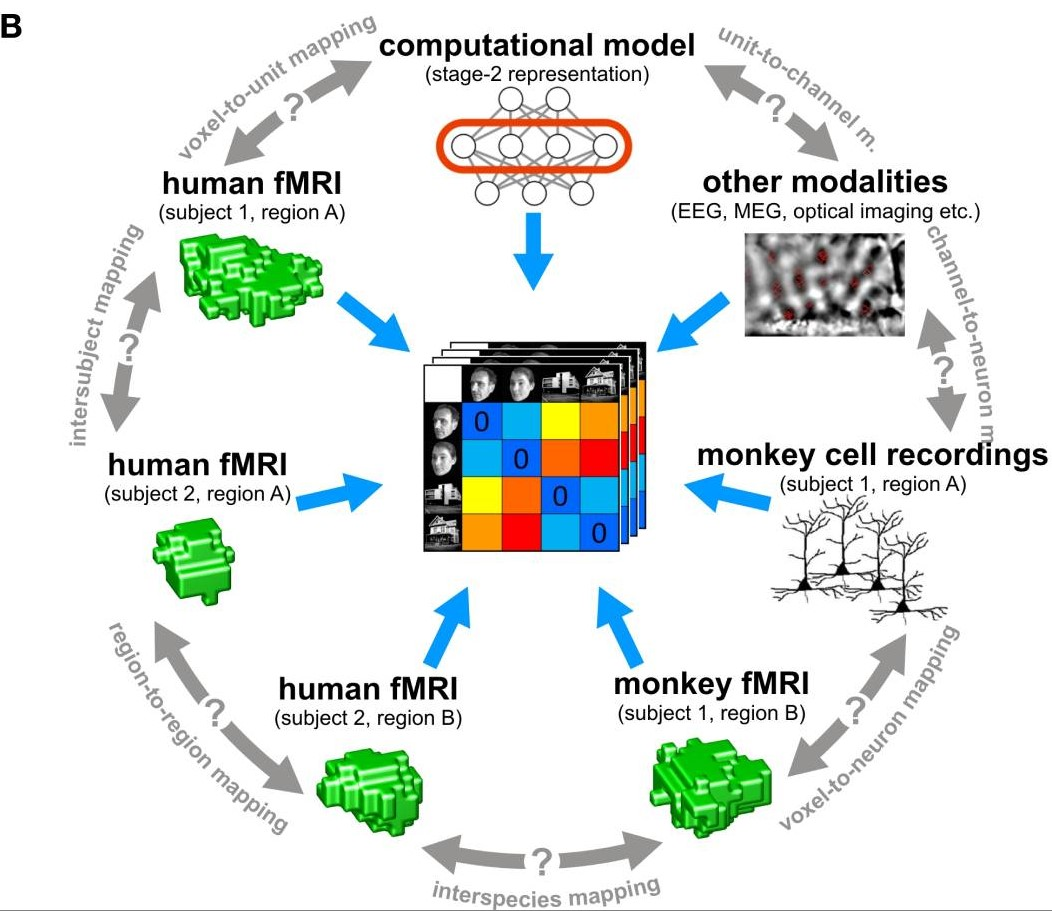

#Dataset from Cichy et al 
There are 92 images used in the dataset. These images belong to different categories as shown in the Figure below. 

In [1]:
#@title Imports
import glob
import numpy as np
import urllib
import torch
import cv2
import argparse
import time
import random
import matplotlib.pyplot as plt
import nibabel as nib
import pickle
from tqdm import tqdm
from PIL import Image
from torchvision import transforms as trn
import scipy.io as sio
import h5py
import os
from PIL import Image
from sklearn.preprocessing import StandardScaler
from torch.autograd import Variable as V
from sklearn.decomposition import PCA, IncrementalPCA
import torch.nn as nn
import torch.utils.model_zoo as model_zoo

def loadmat(matfile):
    """Function to load .mat files.
    Parameters
    ----------
    matfile : str
        path to `matfile` containing fMRI data for a given trial.
    Returns
    -------
    dict
        dictionary containing data in key 'vol' for a given trial.
    """
    try:
        f = h5py.File(matfile)
    except (IOError, OSError):
        return sio.loadmat(matfile)
    else:
        return {name: np.transpose(f.get(name)) for name in f.keys()}

In [2]:
#@title Data download
!wget -qO data.zip -c https://osf.io/7vpyh/download


In [3]:
%%capture
!unzip -o data.zip

# Loading MEG RDMs

In [4]:
MEG_RDMs = loadmat("MEG_decoding_RDMs.mat")['MEG_decoding_RDMs']
print(MEG_RDMs.shape)  

(16, 2, 1301, 92, 92)


Shape of RDM is num_subjects x num_sessions x num_timepoints x num_stimulus x num_stimulus

In [5]:
# average across subjects and sessions
MEG_RDM_sub_averaged = np.mean(MEG_RDMs,axis=(0,1))
del MEG_RDMs

Text(0, 0.5, 'Decoding Accuracy')

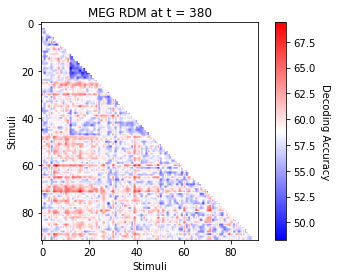

In [6]:
#@title visualize MEG RDMs
timepoint = 380 #@param {type:"slider", min:-100, max:600, step:20}
RDM = np.array(MEG_RDM_sub_averaged[timepoint+100])
RDM[np.triu_indices(RDM.shape[0], 1)] = np.nan
plt.imshow(RDM,\
           cmap="bwr")
plt.title("MEG RDM at t = " + str(timepoint))
cbar = plt.colorbar()
plt.xlabel("Stimuli")
plt.ylabel("Stimuli")
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Decoding Accuracy', rotation=270)

#Loading fMRI RDMs

In [7]:
fMRI_file = '92_Image_Set/target_fmri.mat'
fMRI_RDMs = loadmat(fMRI_file)
print(fMRI_RDMs.keys())
print(fMRI_RDMs['EVC_RDMs'].shape)


dict_keys(['EVC_RDMs', 'IT_RDMs'])
(15, 92, 92)


fMRI_RDMs is a dictionary with keys 'EVC_RDMs' and 'IT_RDMs' corresponding to ROIs EVC and IT respectively. The shape of each RDM is num_subjects x num_stimulus x num_stimulus

Text(0, 0.5, '1-Correlation')

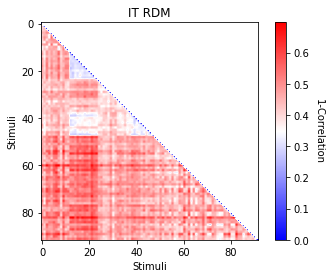

In [8]:
#@title visualize fMRI RDMs
ROI = 'IT' #@param ["EVC", "IT"]

# RDM
RDM = np.array(fMRI_RDMs[ROI + '_RDMs'].mean(axis=0))
RDM[np.triu_indices(RDM.shape[0], 1)] = np.nan
plt.imshow(RDM,\
           cmap="bwr")
plt.title(ROI + " RDM")
cbar = plt.colorbar()
plt.xlabel("Stimuli")
plt.ylabel("Stimuli")
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('1-Correlation', rotation=270)

#fMRI-MEG example



In [9]:
from scipy.stats import spearmanr

def RSA_spearman(rdm1,rdm2):
    lt_rdm1 = get_lowertriangular(rdm1)
    lt_rdm2 = get_lowertriangular(rdm2)
    return spearmanr(lt_rdm1, lt_rdm2)[0]

def get_lowertriangular(rdm):
    num_conditions = rdm.shape[0]
    return rdm[np.triu_indices(num_conditions,1)]

In [10]:
num_timepoints = MEG_RDM_sub_averaged.shape[0]
MEG_correlation = {}
ROIs = ['EVC','IT']
for ROI in ROIs:
  MEG_correlation[ROI] = []

for t in range(num_timepoints):
  MEG_RDM_t = MEG_RDM_sub_averaged[t,:,:]
  for ROI in ROIs:
    ROI_RDM = np.mean(fMRI_RDMs[ROI + '_RDMs'],axis=0)
    MEG_correlation[ROI].append(RSA_spearman(ROI_RDM,MEG_RDM_t))

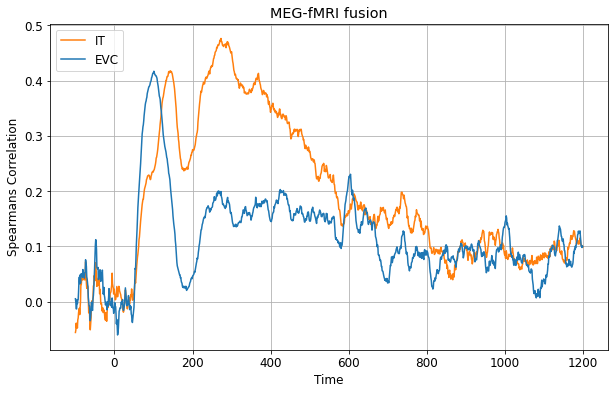

In [11]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(10, 6))

time_range = range(-100,1201)
ax.plot(time_range, MEG_correlation['IT'], color='tab:orange', label='IT')
ax.plot(time_range, MEG_correlation['EVC'], color='tab:blue', label='EVC')

# Same as above
ax.set_xlabel('Time')
ax.set_ylabel('Spearmans Correlation')
ax.set_title('MEG-fMRI fusion')
ax.grid(True)
ax.legend(loc='upper left');

#Creating Computer Vision model RDMs

In [12]:
#@title AlexNet
__all__ = ['AlexNet', 'alexnet']


model_urls = {
    'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',
}


class AlexNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            )
        self.conv3 = nn.Sequential(
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            )
        self.conv4 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            )
        self.conv5 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            )
        self.fc6 = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            )
        self.fc7 =nn.Sequential(
            nn.Dropout(),
            nn.Linear(4096, 4096),
            )
        self.fc8 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
            )

    def forward(self, x):
        out1 = self.conv1(x)
        out2 = self.conv2(out1)
        out3 = self.conv3(out2)
        out4 = self.conv4(out3)
        out5 = self.conv5(out4)

        out5_reshaped = out5.view(out5.size(0), 256 * 6 * 6)
        out6= self.fc6(out5_reshaped)
        out7= self.fc7(out6)
        out8 = self.fc8(out7)
        return out1, out2, out3,out4, out5, out6,out7,out8


def alexnet(pretrained=False, **kwargs):
    r"""AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = AlexNet(**kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['alexnet']))
    return model 

In [13]:
#@title Feature extraction code
def load_alexnet(model_checkpoints):
    """This function initializes an Alexnet and load
    its weights from a pretrained model
    ----------
    model_checkpoints : str
        model checkpoints location.
    Returns
    -------
    model
        pytorch model of alexnet
    """


    model = alexnet()
    model_file = model_checkpoints
    checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
    model_dict =["conv1.0.weight", "conv1.0.bias", "conv2.0.weight", "conv2.0.bias", "conv3.0.weight", "conv3.0.bias", "conv4.0.weight", "conv4.0.bias", "conv5.0.weight", "conv5.0.bias", "fc6.1.weight", "fc6.1.bias", "fc7.1.weight", "fc7.1.bias", "fc8.1.weight", "fc8.1.bias"]
    state_dict={}
    i=0
    for k,v in checkpoint.items():
        state_dict[model_dict[i]] =  v
        i+=1

    model.load_state_dict(state_dict)
    if torch.cuda.is_available():
        model.cuda()
    model.eval()
    return model


def get_activations_and_save(model, image_list, activations_dir):
    """This function generates Alexnet features and save them in a specified directory.
    Parameters
    ----------
    model :
        pytorch model : alexnet.
    image_list : list
        the list contains path to all images.
    activations_dir : str
        save path for extracted features.
    """

    resize = trn.Compose([
            trn.Resize((224,224)),
            trn.ToTensor(),
            trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    for image_file in tqdm(image_list):
        image_file_name = os.path.split(image_file)[-1].split(".")[0]
        activations = []
        img = Image.open(image_file)
        input_img = V(resize(img).unsqueeze(0))
        if torch.cuda.is_available():
            input_img=input_img.cuda()
        x = model.forward(input_img)
        for i,feat in enumerate(x):
            activations.append(feat.data.cpu().numpy().ravel())

        for layer in range(len(activations)):
            save_path = os.path.join(activations_dir, image_file_name+"_"+"layer" + "_" + str(layer+1) + ".npy")
            np.save(save_path,activations[layer])


In [14]:
image_dir = '92_Image_Set/92images'
image_list = glob.glob(image_dir + '/*.jpg')
image_list.sort()
print('Total Number of Images: ', len(image_list))
save_dir = "/content/activations_alexnet"
# load Alexnet
# Download pretrained Alexnet from:
# https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth
# and save in the current directory
checkpoint_path = "/content/alexnet.pth"
if not os.path.exists(checkpoint_path):
    url = "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth"
    urllib.request.urlretrieve(url, "/content/alexnet.pth")
model = load_alexnet(checkpoint_path)

# get and save activations

activations_dir = os.path.join(save_dir)
if not os.path.exists(activations_dir):
    os.makedirs(activations_dir)
print("-------------Saving activations ----------------------------")
get_activations_and_save(model, image_list, activations_dir)

Total Number of Images:  92


  0%|          | 0/92 [00:00<?, ?it/s]

-------------Saving activations ----------------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 92/92 [00:06<00:00, 15.00it/s]


In [15]:
num_layers = 8 
layers = []
for i in range(num_layers):
  layers.append("layer" + "_" + str(i+1))
model_RDMs = {}
scaler = StandardScaler()
for layer in layers:
  activation_files =  glob.glob(activations_dir + '/*'+layer + '.npy')
  activation_files.sort()
  activations = []
  for activation_file  in activation_files:
    activations.append(np.load(activation_file))
  activations = np.array(activations)
  model_RDMs[layer] = 1-np.corrcoef(activations)

Text(0, 0.5, '1-Correlation')

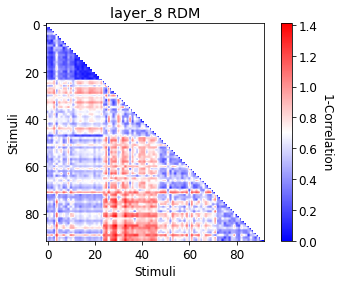

In [16]:
#@title visualize model RDMs
layer = 'layer_8' #@param ['layer_1','layer_2','layer_3','layer_4','layer_5','layer_6','layer_7','layer_8']

RDM = np.array(model_RDMs[layer])
RDM[np.triu_indices(RDM.shape[0], 1)] = np.nan
plt.imshow(RDM,\
           cmap="bwr")
plt.title(layer + " RDM")
cbar = plt.colorbar()
plt.xlabel("Stimuli")
plt.ylabel("Stimuli")
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('1-Correlation', rotation=270)

#MEG-DNN example


In [17]:
num_timepoints = MEG_RDM_sub_averaged.shape[0]

for layer in layers:
  MEG_correlation[layer] = []

for t in range(num_timepoints):
  MEG_RDM_t = MEG_RDM_sub_averaged[t,:,:]
  for layer in layers:
    model_RDM = model_RDMs[layer]
    MEG_correlation[layer].append(RSA_spearman(model_RDM,MEG_RDM_t))

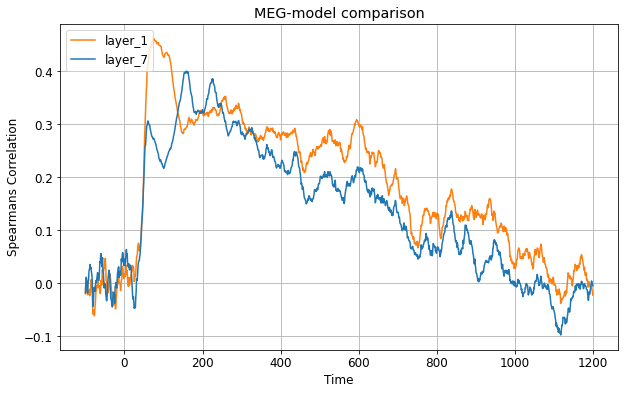

In [18]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(10, 6))

time_range = range(-100,1201)
ax.plot(time_range, MEG_correlation['layer_1'], color='tab:orange', label='layer_1')
ax.plot(time_range, MEG_correlation['layer_7'], color='tab:blue', label='layer_7')

# Same as above
ax.set_xlabel('Time')
ax.set_ylabel('Spearmans Correlation')
ax.set_title('MEG-model comparison')
ax.grid(True)
ax.legend(loc='upper left');

#fMRI-DNN example

In [19]:
fMRI_correlation = {}
for layer in layers:
  fMRI_correlation[layer] = []

for ROI in ROIs:
  ROI_RDM = np.mean(fMRI_RDMs[ROI + '_RDMs'],axis=0)
  for layer in layers:
    model_RDM = model_RDMs[layer]
    fMRI_correlation[layer].append(RSA_spearman(model_RDM,ROI_RDM))

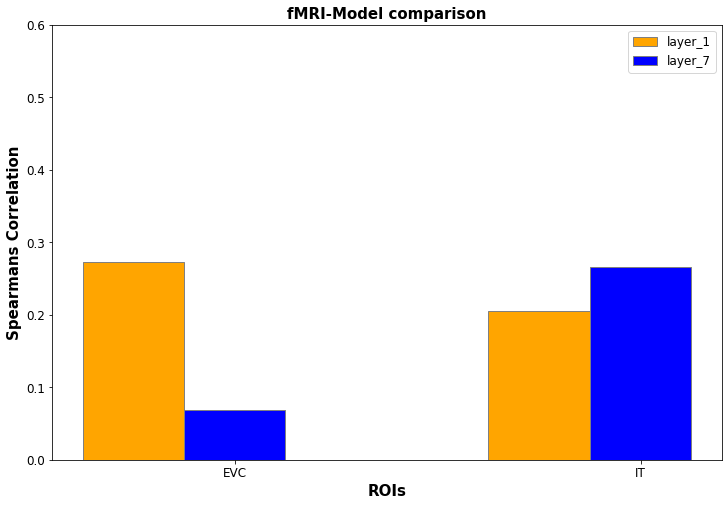

In [20]:
import numpy as np
import matplotlib.pyplot as plt
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))

br1 = np.arange(len(ROIs))
br2 = [x + barWidth for x in br1]

plt.bar(br1, fMRI_correlation['layer_1'], color ='orange', width = barWidth,
        edgecolor ='grey', label ='layer_1')
plt.bar(br2, fMRI_correlation['layer_7'], color ='blue', width = barWidth,
        edgecolor ='grey', label ='layer_7')
 
# Adding Xticks
plt.xlabel('ROIs', fontweight ='bold', fontsize = 15)
plt.ylabel('Spearmans Correlation', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(ROIs))], ROIs)
plt.ylim(0,0.6)
plt.legend()
plt.title("fMRI-Model comparison", fontweight ='bold', fontsize = 15)
plt.show()

#References
1.   [Resolving human object recognition in space and time. Cichy et al. Nature Neuroscience 2014](https://www.nature.com/articles/nn.3635)
2.   [Representational similarity analysis – connecting the branches of systems neuroscience. Kriegeskorte et al. Front. Syst. Neurosci., 2008](https://www.frontiersin.org/articles/10.3389/neuro.06.004.2008/full?utm_source=FWEB&utm_medium=NBLOG&utm_campaign=ECO_10YA_top-research)



